In [94]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

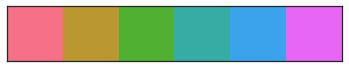

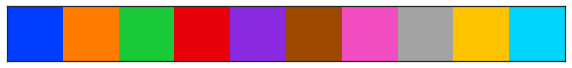

In [95]:
import seaborn as sns

NESTS = ['E1', 'E2', 'E3', 'E4', 'E5', 'U1', 'U2', 'U3', 'U4', 'U5']
POSTNATALDAYS = [1, 2, 4, 5, 9, 10]
MOTHERS = ['E', 'U']

POSTNATALDAYPALETTE = sns.husl_palette(n_colors=len(POSTNATALDAYS), h=0.01, s=0.9, l=0.65)
NESTPALETTE = sns.color_palette("bright", n_colors=len(NESTS), desat=1)

COLORS = {
    'vocalization': {
        1: 'tab:blue',
        2: 'tab:orange'
    },
    'postnatalday': dict(zip(POSTNATALDAYS, POSTNATALDAYPALETTE)),
    'nest': dict(zip(NESTS, NESTPALETTE)),
    'mother': {
        'E': '#FFFF00',  # yellow
        'U': '#FF8C00'  # orange
    }
}

sns.palplot(POSTNATALDAYPALETTE)
sns.palplot(NESTPALETTE)

In [105]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set(style="white", palette="bright", color_codes=True)
sns.despine(left=True)

from audiovocana.dataset import get_dataset
from audiovocana.preprocessing import get_dataframe

PLOT = True
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results/distributions"

<Figure size 432x288 with 0 Axes>

In [97]:
# full
csv_path = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
xlsx_folder = "/home/utilisateur/Desktop/palomars/data/full/xlsx_files"
audio_folder = "/media/utilisateur/LACIE SHARE/paloma-USV-data/audio"

In [98]:
df = get_dataframe(
    xlsx_folder=xlsx_folder,
    audio_folder=audio_folder,
    csv_path=csv_path,
    save=True
)
print(f"Nb audibles = {len(df[df.vocalization == 1])}")
print(f"Nb USVs = {len(df[df.vocalization == 2])}")
print(f"Audible events represents the {len(df[df.vocalization == 1])/len(df)}% of total.")

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings
Nb audibles = 2204
Nb USVs = 2013
Audible events represents the 0.522646431112165% of total.


In [99]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


In [100]:
records = []
for sample in tqdm(iter(dataset)): 
    records.append({
        'year': sample['year'].numpy(),
        'nest': sample['nest'].numpy().decode(),
        'mother': sample['mother'].numpy().decode(),
        'postnatalday': sample['postnatalday'].numpy(),
        'vocalization': sample['vocalization'].numpy(),
        'mean_spectral_band_width': sample['mean_sbw'].numpy(),
        'mean_spectral_centroid': sample['mean_sc'].numpy(),
        'mean_spectral_flatness': sample['mean_sf'].numpy(),
        'mean_zero_crossing_rate': sample['mean_zrc'].numpy(),
    })
df = pd.DataFrame.from_records(records)

2847it [00:17, 163.87it/s]


# simple audio features distribution by postnatal day

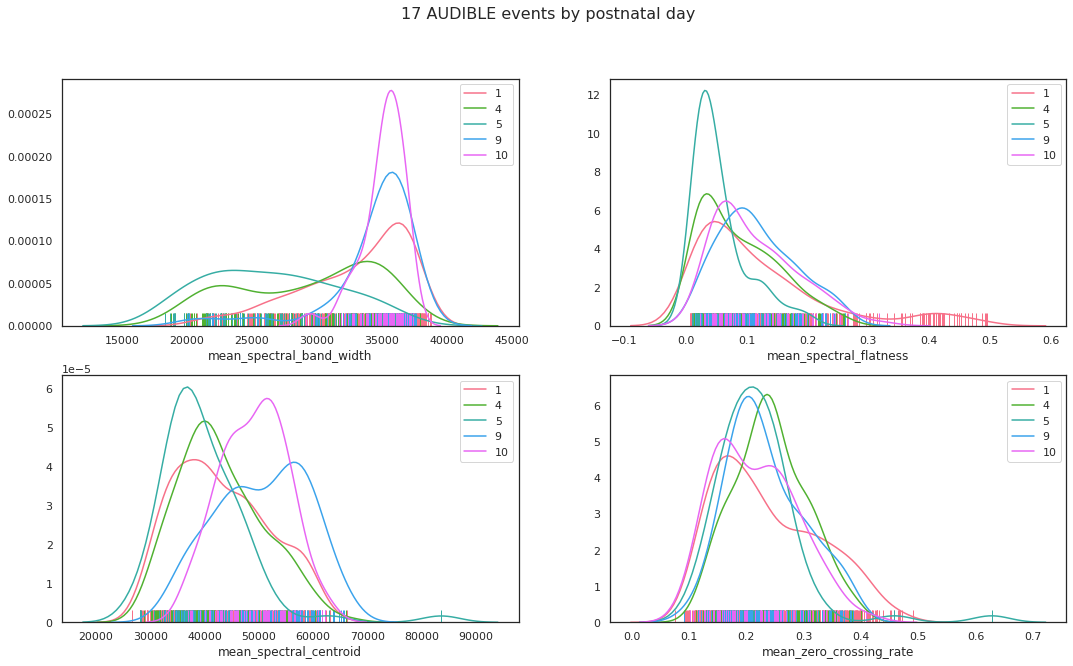

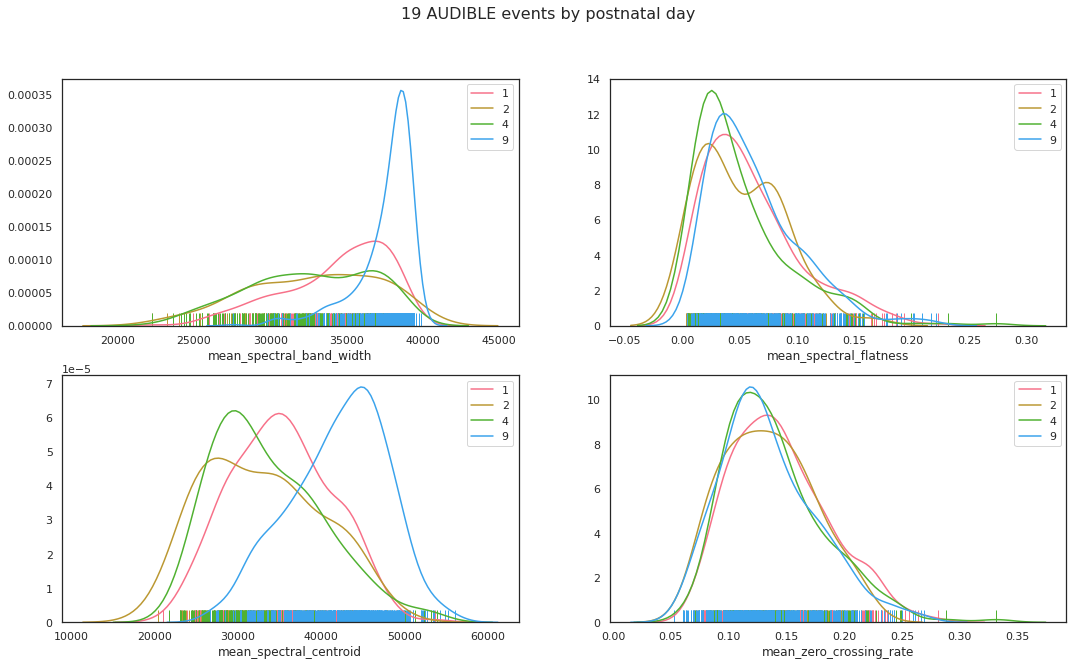

In [108]:
dicc_pnds = COLORS['postnatalday']

P = {
    p: df[(df.postnatalday == p) & (df.vocalization == 1)]
    for p in POSTNATALDAYS
}

for YEAR in [17, 19]:

    PY = {
        p: P[p][P[p].year == YEAR]
        for p in POSTNATALDAYS 
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by postnatal day'
    f.suptitle(title, fontsize=16)

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_spectral_band_width, color=dicc_pnds[p],  hist=False, rug=True, ax=axes[0, 0], kde_kws={"label": f"{p}"})

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_spectral_flatness,color=dicc_pnds[p],  hist=False, rug=True, ax=axes[0, 1], kde_kws={"label": f"{p}"})

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_spectral_centroid, color=dicc_pnds[p],  hist=False, rug=True, ax=axes[1, 0], kde_kws={"label": f"{p}"})

    for p in POSTNATALDAYS:
        sns.distplot(PY[p].mean_zero_crossing_rate, color=dicc_pnds[p],  hist=False, rug=True, ax=axes[1, 1], kde_kws={"label": f"{p}"})
        
    f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))

# simple audio features distribution for experienced (E) vs unexperienced (U) mothers

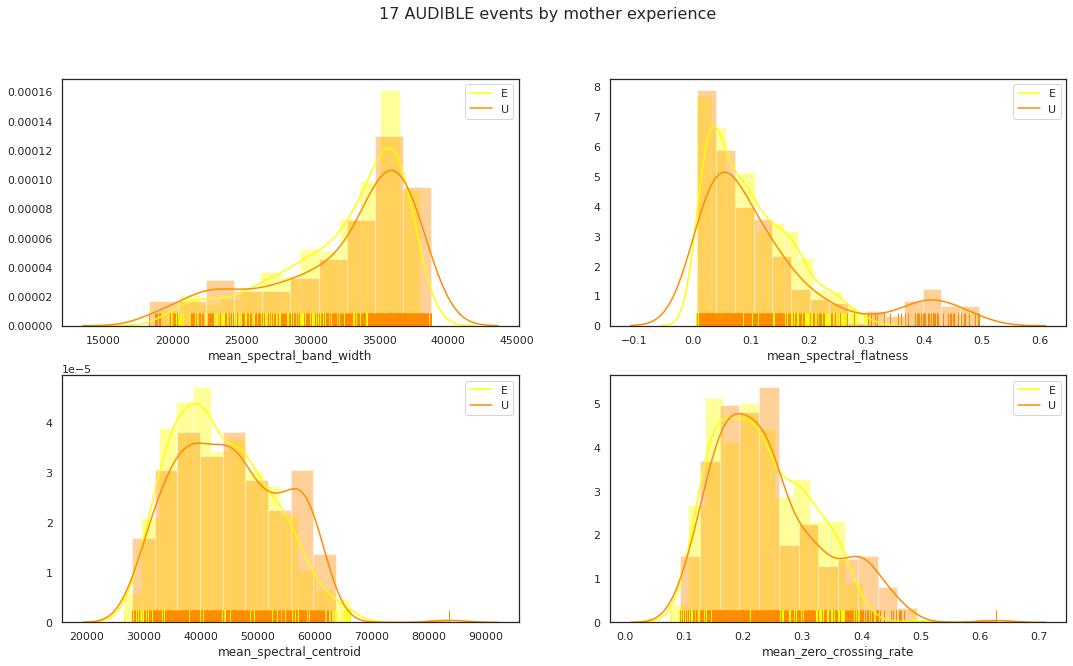

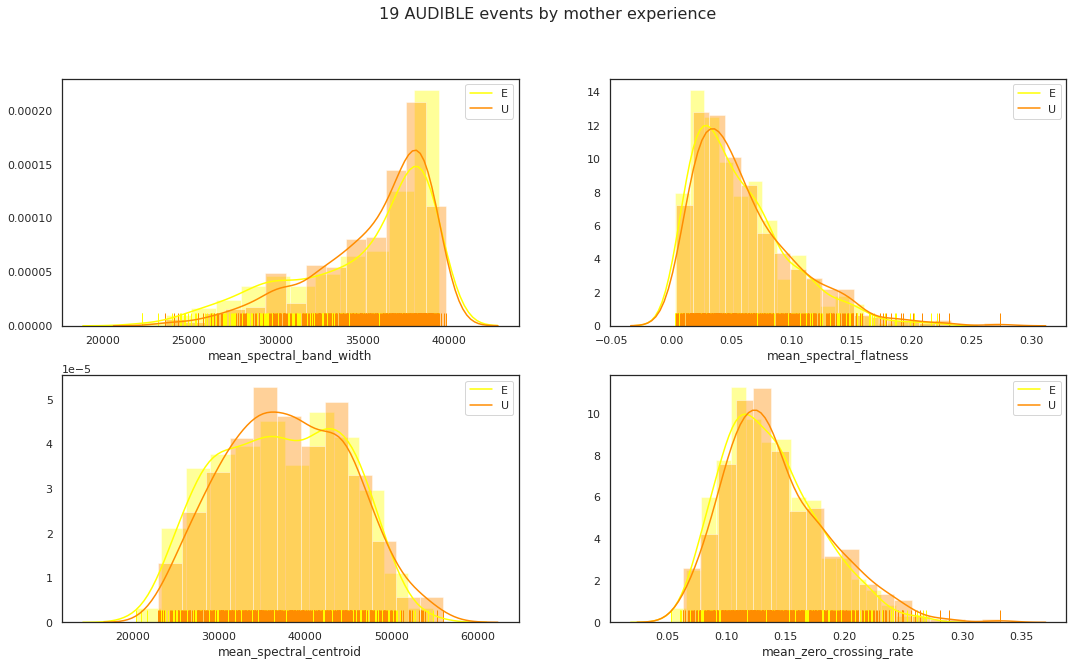

In [110]:
dicc_mothers = COLORS['mother']

M = {
    m: df[(df.mother == m) & (df.vocalization == 1)]
    for m in MOTHERS
}

for YEAR in [17, 19]:

    MY = {
        m: M[m][M[m].year == YEAR]
        for m in MOTHERS 
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by mother experience'
    f.suptitle(title, fontsize=16)

    for m in MOTHERS:
        sns.distplot(MY[m].mean_spectral_band_width, color=dicc_mothers[m], rug=True, ax=axes[0, 0], kde_kws={"label": f"{m}"})

    for m in MOTHERS:
        sns.distplot(MY[m].mean_spectral_flatness, color=dicc_mothers[m], rug=True, ax=axes[0, 1], kde_kws={"label": f"{m}"})

    for m in MOTHERS:
        sns.distplot(MY[m].mean_spectral_centroid, color=dicc_mothers[m], rug=True, ax=axes[1, 0], kde_kws={"label": f"{m}"})

    for m in MOTHERS:
        sns.distplot(MY[m].mean_zero_crossing_rate, color=dicc_mothers[m], rug=True, ax=axes[1, 1], kde_kws={"label": f"{m}"})
    
    f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))

# simple audio features distribution for experienced (E) vs unexperienced (U) mothers

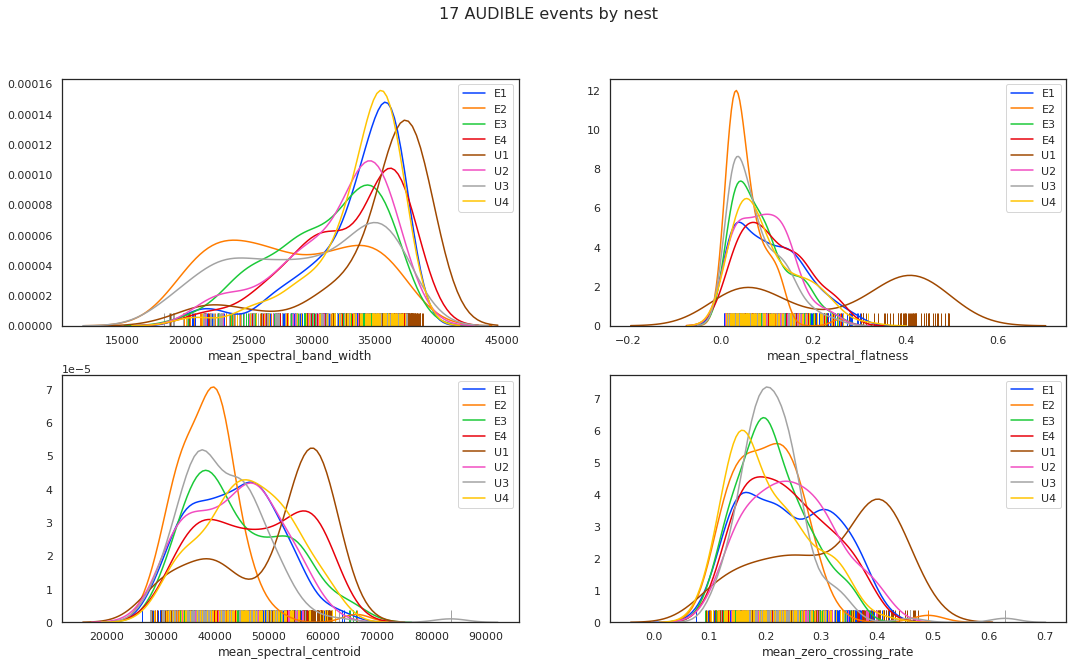

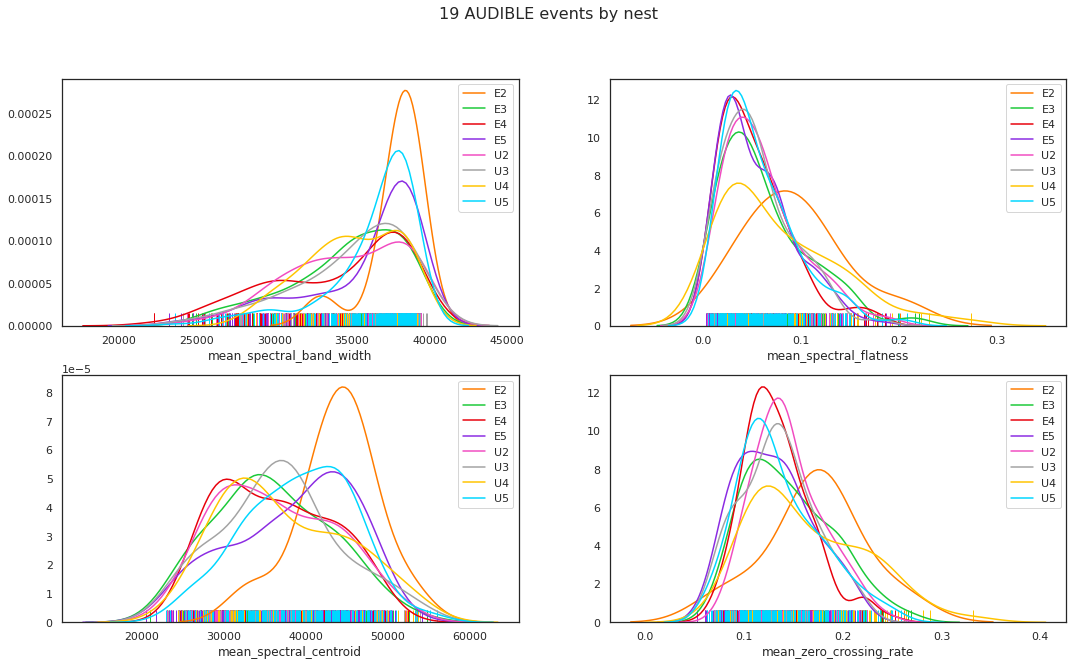

In [111]:
dicc = COLORS['nest']

M = {
    m: df[(df.nest == m) & (df.vocalization == 1)]
    for m in NESTS
}

for YEAR in [17, 19]:

    MY = {
        m: M[m][M[m].year == YEAR]
        for m in NESTS
    }

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by nest'
    f.suptitle(title, fontsize=16)
    
    
    for m in NESTS:
        sns.distplot(MY[m].mean_spectral_band_width, color=dicc[m], hist=False, rug=True, ax=axes[0, 0], kde_kws={"label": f"{m}"})

    for m in NESTS:
        sns.distplot(MY[m].mean_spectral_flatness,color=dicc[m], hist=False, rug=True, ax=axes[0, 1], kde_kws={"label": f"{m}"})

    for m in NESTS:
        sns.distplot(MY[m].mean_spectral_centroid, color=dicc[m], hist=False, rug=True, ax=axes[1, 0], kde_kws={"label": f"{m}"})

    for m in NESTS:
        sns.distplot(MY[m].mean_zero_crossing_rate, color=dicc[m], hist=False, rug=True, ax=axes[1, 1], kde_kws={"label": f"{m}"})
        
        f.savefig(os.path.join(RESULTS_FOLDER, '-'.join(title.split(' '))+'.png'))